# P-210 Fake Bills Detection

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import BaggingClassifier,StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from pickle import dump

import warnings 
warnings.filterwarnings("ignore")

In [3]:
# Read Dataset
df = pd.read_csv("fake_bills.csv",sep=";")
df.sample(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1442,False,171.40,104.21,104.44,5.59,3.30,111.09
967,True,172.36,104.09,103.75,3.98,2.93,112.70
1206,False,171.73,104.09,104.47,4.81,3.46,112.30
663,True,171.80,103.78,103.65,3.73,3.12,113.63
292,True,172.09,103.14,103.81,4.88,3.01,113.69
821,True,172.29,104.04,103.94,3.81,3.00,113.60
2,True,172.69,104.48,103.50,4.40,2.94,113.16
1217,False,171.63,104.61,104.29,5.31,3.14,111.51
723,True,171.99,103.97,103.89,4.22,3.17,113.12
148,True,172.46,103.99,104.04,4.14,2.68,112.93


- Data Dictionary    
    - diagonal -- the diagonal of the bill in mm
    - height left -- the height of the left side of the bill in mm
    - height right -- the height of the right side of the bill in mm
    - margin low -- lower side margin in mm
    - margin up -- upper side margin in mm
    - length -- the length of the bill in mm

## Exploratory Data Analysis

In [4]:
print("The number of features in the 'fake_bills.csv' dataset is {0} and the feature names are \"{1}\".".format(len(df.columns),'", "'.join(df.columns.to_list())))

The number of features in the 'fake_bills.csv' dataset is 7 and the feature names are "is_genuine", "diagonal", "height_left", "height_right", "margin_low", "margin_up", "length".


In [5]:
print("The number of records in the dataset are {}.".format(df.shape[0]))

The number of records in the dataset are 1500.


In [57]:
df.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.481627,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.656137,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.030000,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.860000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [7]:
# Checking for any null values
df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [8]:
# Checking For null values percentage 
(df.isnull().sum()/df.shape[0])*100

is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      2.466667
margin_up       0.000000
length          0.000000
dtype: float64

#### Following are the null values found in margin_low column

In [9]:
df[df["margin_low"].isna()]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


#### Replacing null values with median as the amount of null values is less than 3%

In [10]:
print("The median value for feature 'margin_low' is ",df["margin_low"].median())
print("The mean value for feature 'margin_low' is ",round(df["margin_low"].mean(),2))

The median value for feature 'margin_low' is  4.31
The mean value for feature 'margin_low' is  4.49


In [11]:
# Fill null values with the median
df.fillna(df['margin_low'].median(), inplace=True)

In [12]:
le = LabelEncoder()

df["is_genuine"] = le.fit_transform(df["is_genuine"])

In [13]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [14]:
# Checking for any duplicated records
df[df.duplicated(keep=False)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


There are no duplicated records

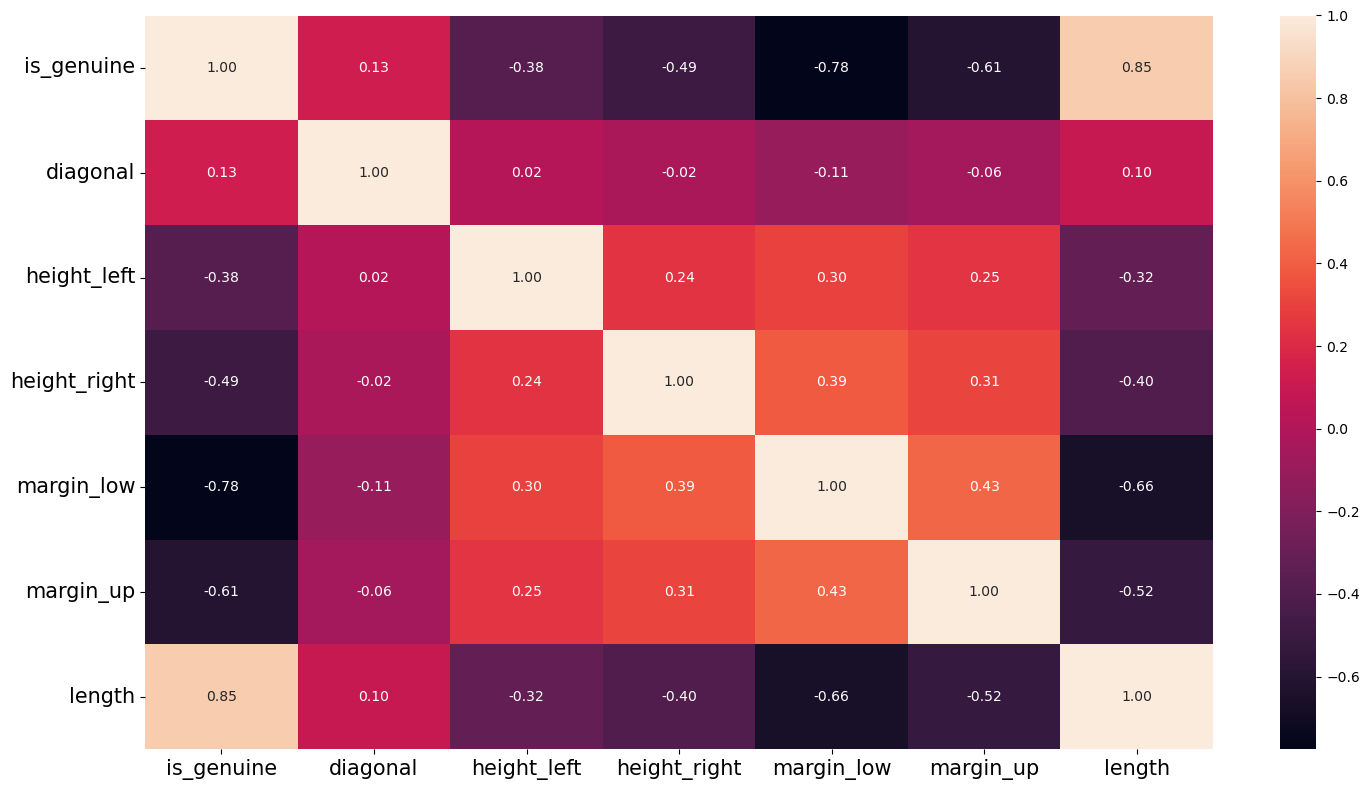

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(data=df.corr(),annot=True,fmt="0.2f")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.tight_layout()
plt.show()

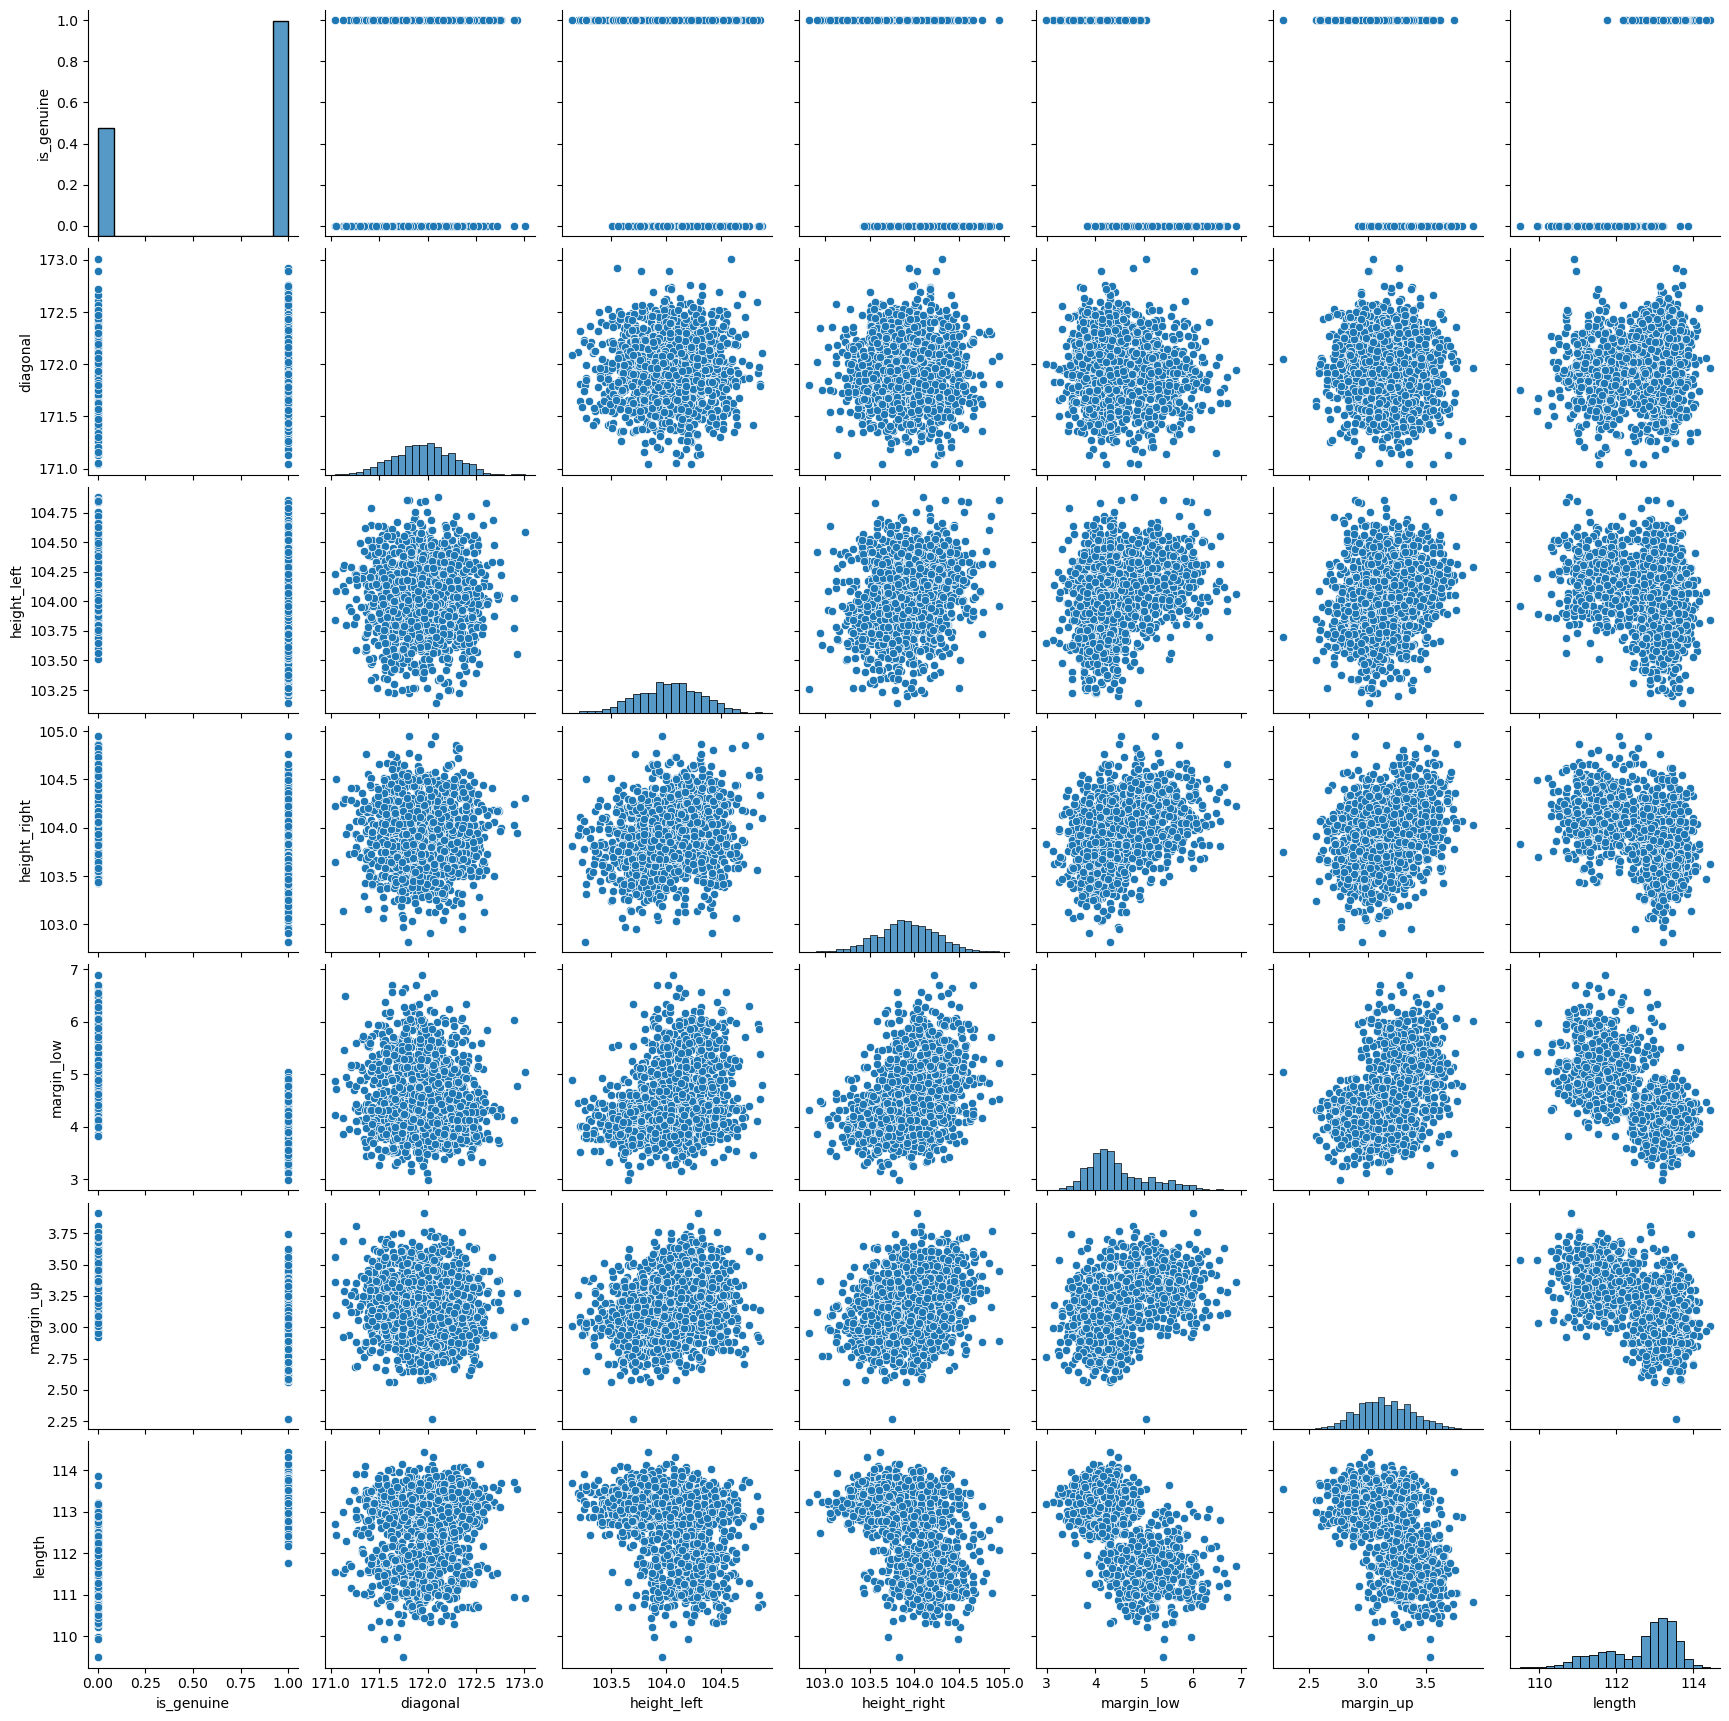

In [16]:
sns.pairplot(df)

#### From the above pairplot we can see that length and margin_low columns are left and right skewed respectively

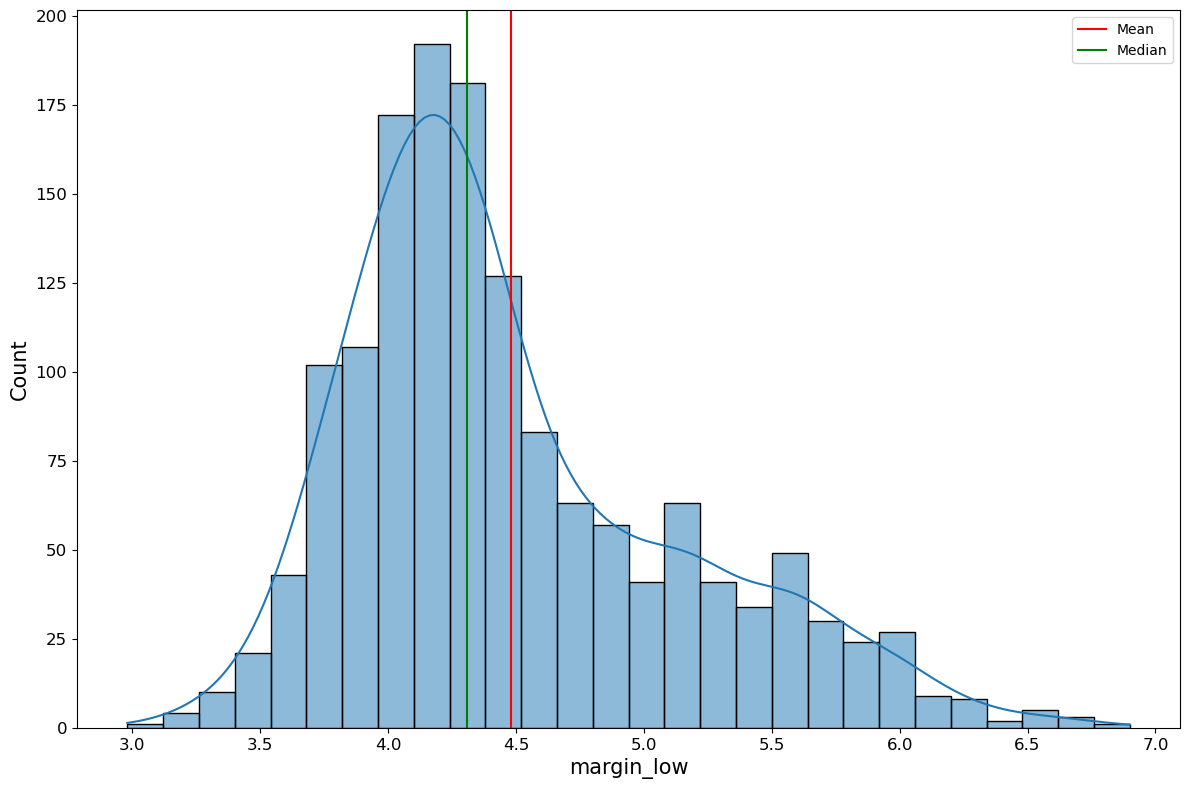

In [17]:
plt.figure(figsize=(12,8))
sns.histplot(df['margin_low'], kde=True)
plt.axvline(df['margin_low'].mean(), c='red',label="Mean")
plt.axvline(df['margin_low'].median(), c='green',label="Median")
plt.xlabel('margin_low',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.legend()
plt.show()

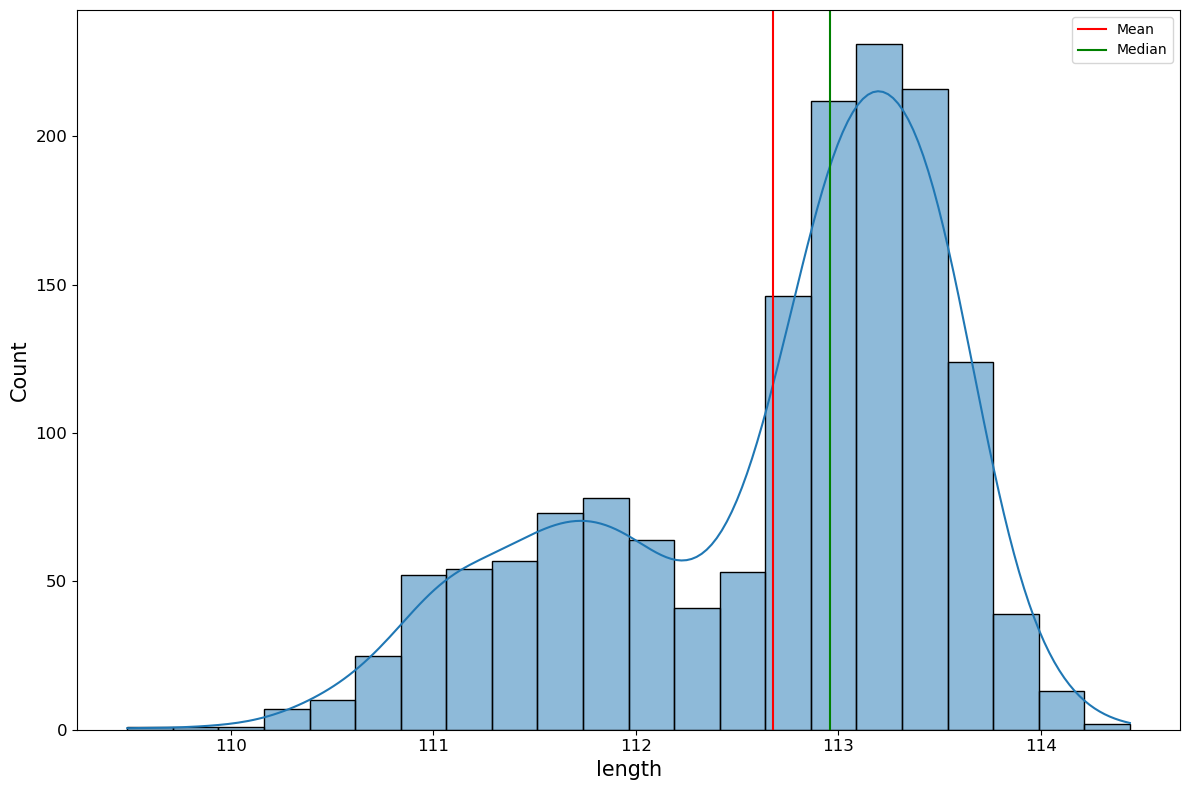

In [18]:
plt.figure(figsize=(12,8))
sns.histplot(df['length'], kde=True)
plt.axvline(df['length'].mean(), c='red',label="Mean")
plt.axvline(df['length'].median(), c='green',label="Median")
plt.xlabel('length',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.legend()
plt.show()

#### Checking for outliers using Z-Score

In [19]:
z = np.abs(zscore(df.iloc[:, 1:]))

In [20]:
z

,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.486540,2.774123,3.163240,0.058503,1.128325,0.173651
1,1.633729,2.236535,0.799668,1.084932,0.696799,0.471666
2,2.397823,1.504756,1.291191,0.124446,0.912562,0.551901
3,1.961498,0.399294,0.060498,1.313618,0.610494,0.953075
4,0.748754,0.836669,1.414072,0.673295,1.417677,0.158750
...,...,...,...,...,...,...
1495,0.683201,1.170713,0.767063,0.093955,0.265273,1.602978
1496,0.758981,2.005822,1.596509,1.201938,0.942999,1.958303
1497,0.519316,0.065250,0.613462,1.567837,0.899846,0.835016
1498,0.332882,0.836669,0.429141,1.049480,1.331372,0.491152


In [21]:
outliers_idx = z[z.values >= 3].index # == np.where(z >= 3)
len(outliers_idx)

24

### Outliers indexes

In [22]:
df.iloc[outliers_idx, :]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
251,1,171.80,103.26,102.82,4.31,2.95,113.22
522,1,172.02,104.42,102.91,3.86,3.12,113.43
664,1,172.05,103.70,103.75,5.04,2.27,113.55
729,1,171.04,103.84,103.64,4.22,3.36,112.70
828,1,172.92,103.55,103.94,4.78,3.27,113.55
842,1,172.89,103.77,104.24,4.12,3.01,113.72
1022,0,172.89,104.03,104.03,6.03,3.00,110.95
1027,0,171.63,104.02,104.66,6.70,3.28,111.28
1029,0,171.96,104.29,104.03,6.01,3.91,110.83


### Removing outliers

In [23]:
clean_df = df.drop(index=outliers_idx) # == df.drop(outliers_idx, axis=0)
clean_df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54
5,1,172.17,103.74,104.08,4.42,2.95,112.81
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0,172.06,104.28,104.06,5.17,3.46,112.25


In [24]:
# Value counts for the Target feature "is_genuine"

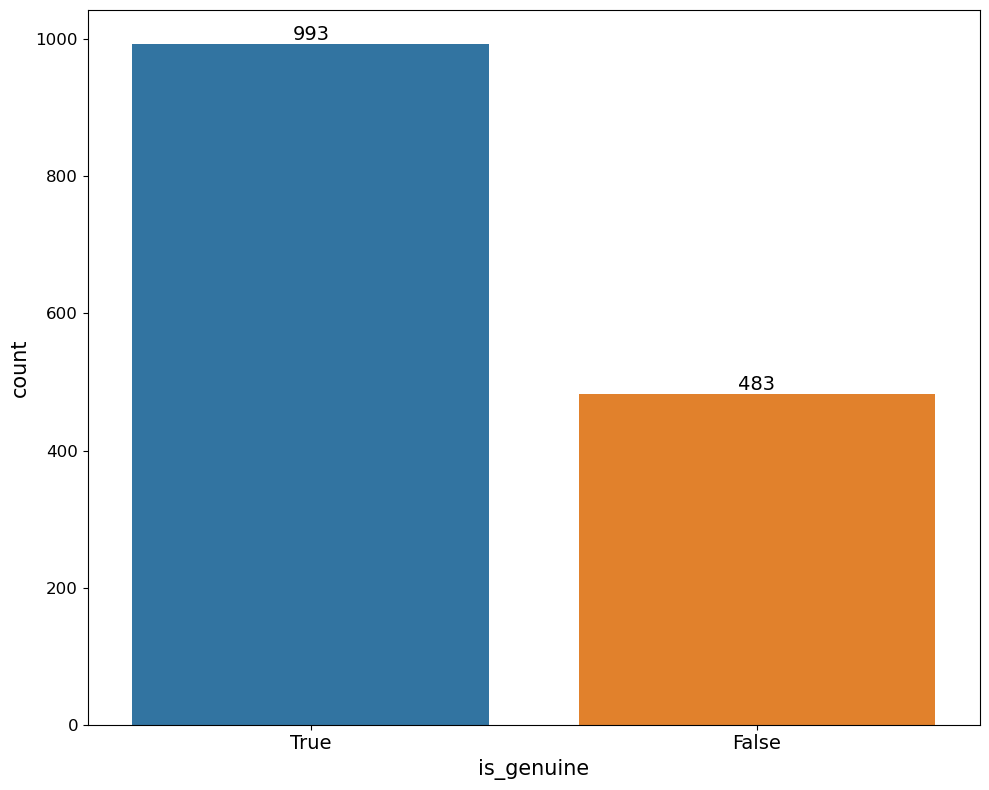

In [25]:
plt.figure(figsize=(10,8))
sns.countplot(x=clean_df['is_genuine'],order=[1,0])
plt.xticks([0,1],["True","False"],fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel("is_genuine",fontsize=15)
plt.ylabel("count",fontsize=15)
plt.text(0,clean_df['is_genuine'].value_counts()[1],clean_df['is_genuine'].value_counts()[1],ha="center",va="bottom",fontsize=14)
plt.text(1,clean_df['is_genuine'].value_counts()[0],clean_df['is_genuine'].value_counts()[0],ha="center",va="bottom",fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
# Separate features and target variable

X = clean_df.drop('is_genuine', axis=1)
y = clean_df['is_genuine']

In [28]:
# Apply SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [29]:
# Combine resampled features and target variable

balanced_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

In [30]:
balanced_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,171.46,103.36,103.66,3.77,2.99,113.09,1
1,172.69,104.48,103.50,4.40,2.94,113.16,1
2,171.36,103.91,103.94,3.62,3.01,113.51,1
3,171.73,104.28,103.46,4.04,3.48,112.54,1
4,172.17,103.74,104.08,4.42,2.95,112.81,1


In [31]:
balanced_df['is_genuine'].value_counts()

1    993
0    993
Name: is_genuine, dtype: int64

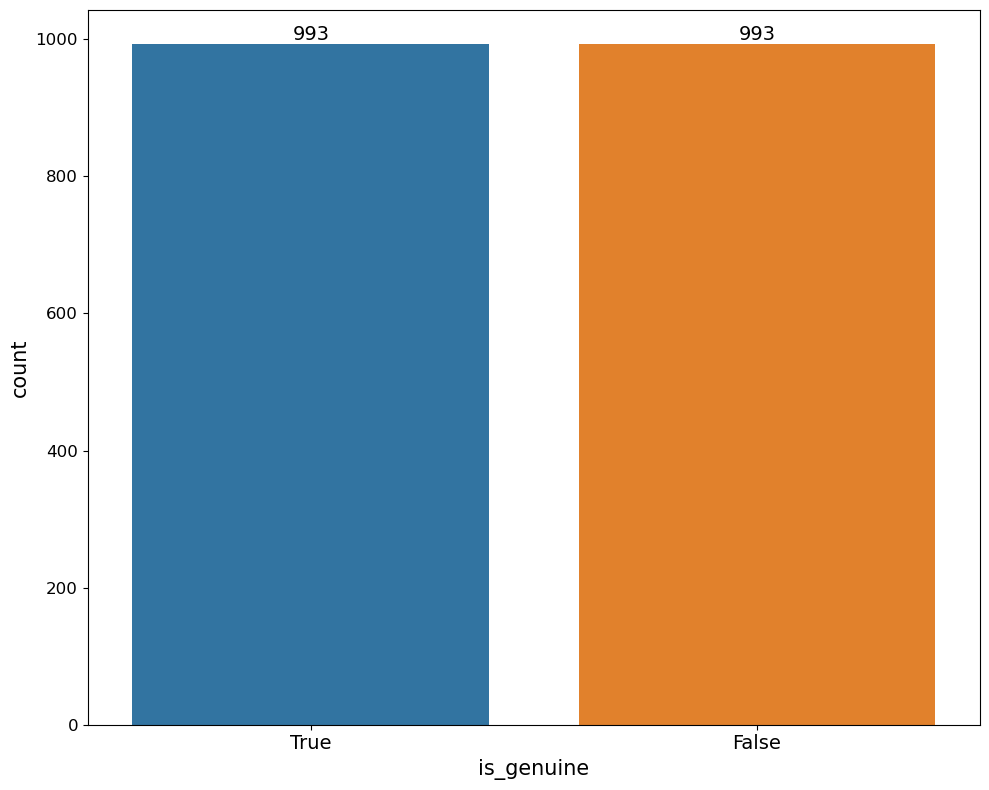

In [32]:
plt.figure(figsize=(10,8))
sns.countplot(x=balanced_df['is_genuine'],order=[1,0])
plt.xticks([0,1],["True","False"],fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel("is_genuine",fontsize=15)
plt.ylabel("count",fontsize=15)
plt.text(0,balanced_df['is_genuine'].value_counts()[1],balanced_df['is_genuine'].value_counts()[1],ha="center",va="bottom",fontsize=14)
plt.text(1,balanced_df['is_genuine'].value_counts()[0],balanced_df['is_genuine'].value_counts()[0],ha="center",va="bottom",fontsize=14)
plt.tight_layout()
plt.show()

In [33]:
balanced_df.shape

(1986, 7)

In [39]:
clean_df = pd.read_csv('cleaned_fake_bills.csv', index_col=0)
clean_df.sample(10)

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
192,172.35000,103.730000,102.950000,4.49000,3.37000,112.490000,1
695,171.71000,103.520000,103.340000,4.12000,3.31000,113.150000,1
842,172.02000,104.070000,104.130000,3.72000,2.96000,112.560000,1
734,172.07000,103.740000,103.760000,4.31000,3.09000,112.410000,1
1256,172.33000,104.360000,104.310000,4.40000,3.33000,112.030000,0
1251,171.94000,104.380000,103.810000,4.87000,3.39000,111.220000,0
1979,171.94335,104.142714,103.856259,4.45665,3.23379,112.093154,0
85,172.01000,104.580000,103.890000,3.96000,2.87000,113.280000,1
753,171.66000,104.120000,103.940000,4.44000,3.19000,113.250000,1
1222,172.27000,103.880000,104.160000,5.91000,3.31000,110.910000,0


In [130]:
x = clean_df.iloc[:, :-1]
y = clean_df.iloc[:, -1]

## Feature Engineering

#### We will be doing feature engineering using 2 methods
    - Univariate selection method
    - Tree based method

### Univariate Selection

In [131]:
uni_test = SelectKBest(score_func=chi2, k='all')
uni_test.fit(x, y)
uni_test

SelectKBest(k='all', score_func=<function chi2 at 0x00000274D9383E50>)

In [132]:
scores = uni_test.scores_
scores

array([2.01614128e-02, 2.68259030e-01, 5.23835340e-01, 1.18319547e+02,
       1.35104984e+01, 1.06843217e+01])

In [133]:
imp_cols = pd.DataFrame({'Chi_score': scores}, index=x.columns)
imp_cols.sort_values(by='Chi_score', ascending=False)

,Chi_score
margin_low,118.319547
margin_up,13.510498
length,10.684322
height_right,0.523835
height_left,0.268259
diagonal,0.020161


### Tree based method

In [134]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(x, y)
dt.feature_importances_

array([0.00408612, 0.        , 0.01798318, 0.13071663, 0.04224869,
       0.80496539])

In [135]:
pd.DataFrame(dt.feature_importances_, index=x.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

,Importance
length,0.804965
margin_low,0.130717
margin_up,0.042249
height_right,0.017983
diagonal,0.004086
height_left,0.000000


#### We can see that in both the methods `margin_low`, `margin_up` and `length` are the most important
#### But since there are only 6 columns in the dataset which is very low, we will be using all the columns to build the model

## Model validation

### Train Test Split

In [136]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42, test_size=0.2)

## Model Building

### ANN

In [183]:
ann = Sequential()

ann.add(Dense(units=10, activation='relu'))
ann.add(Dense(units=8, activation='relu'))
ann.add(Dense(units=5, activation='relu'))
ann.add(Dense(units=1, activation='sigmoid'))

ann.compile(optimizer='adam', loss='binary_crossentropy')
ann.fit(xtrain, ytrain, epochs=350, validation_data=(xtest, ytest))

Epoch 1/350
50/50 [==============================] - 1s 4ms/step - loss: 0.7543 - val_loss: 0.7097
Epoch 2/350
50/50 [==============================] - 0s 2ms/step - loss: 0.7114 - val_loss: 0.7097
Epoch 3/350
50/50 [==============================] - 0s 2ms/step - loss: 0.7153 - val_loss: 0.7248
Epoch 4/350
50/50 [==============================] - 0s 3ms/step - loss: 0.7099 - val_loss: 0.6938
Epoch 5/350
50/50 [==============================] - 0s 3ms/step - loss: 0.7218 - val_loss: 0.6923
Epoch 6/350
50/50 [==============================] - 0s 3ms/step - loss: 0.7065 - val_loss: 0.7033
Epoch 7/350
50/50 [==============================] - 0s 3ms/step - loss: 0.7077 - val_loss: 0.6935
Epoch 8/350
50/50 [==============================] - 0s 2ms/step - loss: 0.6993 - val_loss: 0.6860
Epoch 9/350
50/50 [==============================] - 0s 3ms/step - loss: 0.6892 - val_loss: 0.6787
Epoch 10/350
50/50 [==============================] - 0s 3ms/step - loss: 0.7027 - val_loss: 0.6753
Epoch 11/

50/50 [==============================] - 0s 2ms/step - loss: 0.2197 - val_loss: 0.2043
Epoch 84/350
50/50 [==============================] - 0s 3ms/step - loss: 0.2210 - val_loss: 0.1824
Epoch 85/350
50/50 [==============================] - 0s 3ms/step - loss: 0.2116 - val_loss: 0.1797
Epoch 86/350
50/50 [==============================] - 0s 3ms/step - loss: 0.2366 - val_loss: 0.1824
Epoch 87/350
50/50 [==============================] - 0s 3ms/step - loss: 0.2096 - val_loss: 0.2315
Epoch 88/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1962 - val_loss: 0.1752
Epoch 89/350
50/50 [==============================] - 0s 2ms/step - loss: 0.2005 - val_loss: 0.1774
Epoch 90/350
50/50 [==============================] - 0s 2ms/step - loss: 0.2019 - val_loss: 0.1677
Epoch 91/350
50/50 [==============================] - 0s 4ms/step - loss: 0.1997 - val_loss: 0.1702
Epoch 92/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1961 - val_loss: 0.1697
Epoch 93/350


50/50 [==============================] - 0s 3ms/step - loss: 0.1089 - val_loss: 0.0793
Epoch 246/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1159 - val_loss: 0.0782
Epoch 247/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1159 - val_loss: 0.0785
Epoch 248/350
50/50 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.0776
Epoch 249/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.0982
Epoch 250/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1278 - val_loss: 0.0774
Epoch 251/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1035 - val_loss: 0.1307
Epoch 252/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1201 - val_loss: 0.0767
Epoch 253/350
50/50 [==============================] - 0s 2ms/step - loss: 0.1087 - val_loss: 0.1089
Epoch 254/350
50/50 [==============================] - 0s 3ms/step - loss: 0.1124 - val_loss: 0.0969
Epoc

<AxesSubplot:>

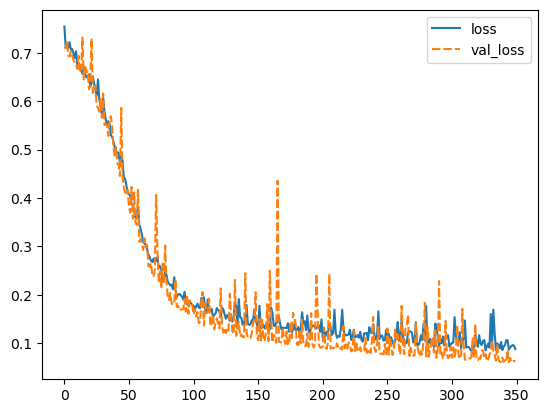

In [184]:
sns.lineplot(ann.history.history)

In [185]:
ypred_prob = ann.predict(xtest)
ypred = np.where(ypred_prob > 0.5, 1, 0)
ypred[:30].reshape(-1, 1)

13/13 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1]])

In [186]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       198
           1       0.96      0.99      0.98       200

    accuracy                           0.97       398
   macro avg       0.98      0.97      0.97       398
weighted avg       0.98      0.97      0.97       398



In [187]:
ann_accuracy = round(accuracy_score(ytest, ypred), 3)
ann_accuracy

0.975

#### Accuracy is `97.5%` when the threshold is 0.5
#### We will try to increase the accuracy by changing the threshold

### ROC AUC

In [188]:
auc = roc_auc_score(ytest, ypred_prob)
auc

0.9985858585858587

#### AUC of the model is `0.9985`

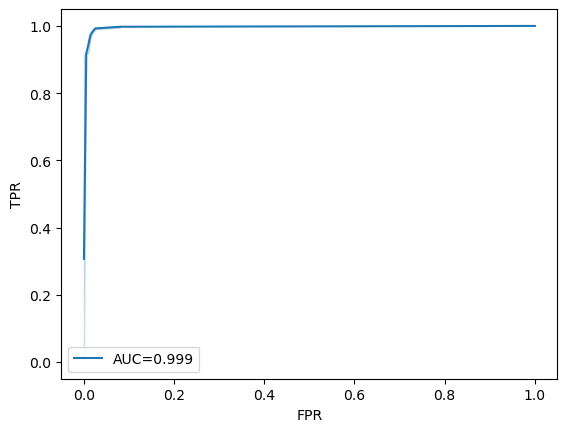

In [190]:
fpr, tpr, thresh = roc_curve(ytest, ypred_prob)
sns.lineplot(x=fpr, y=tpr, label=f'AUC={round(auc, 3)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### Selecting the threshold with the best accuracy

In [191]:
acc = []

for i in thresh:
    ypred = np.where(ypred_prob > i, 1, 0)
    acc.append(accuracy_score(ytest, ypred))
    
thresh_df = pd.DataFrame({'Accuracy': acc, 'Thresh': thresh})
thresh_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,Thresh
11,0.984925,0.606010
9,0.982412,0.652344
10,0.982412,0.620981
12,0.982412,0.603639
7,0.979899,0.718892
8,0.979899,0.691288
6,0.977387,0.729589
13,0.959799,0.340447
3,0.957286,0.889250
5,0.957286,0.862132


#### From above table we can see that when threshold is `0.606010`, accuracy is the highest, so we'll be using this threshold

In [192]:
ypred = np.where(ypred_prob > 0.606010, 1, 0)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       198
           1       0.98      0.99      0.99       200

    accuracy                           0.98       398
   macro avg       0.98      0.98      0.98       398
weighted avg       0.98      0.98      0.98       398



In [193]:
ann_accuracy = round(accuracy_score(ytest, ypred), 3)
ann_accuracy

0.985

#### So the model's accuracy after selecting the best threshold is `98.5%` 

## ANN -  Hyper Parameter Tuning

### Early Stopping

In [194]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [199]:
early_model = Sequential()
early_model.add(Dense(units=10, activation='relu'))

early_model.add(Dense(units=8, activation='relu'))

early_model.add(Dense(units=5, activation='relu'))

early_model.add(Dense(units=1, activation='sigmoid'))

early_model.compile(optimizer='adam', loss='binary_crossentropy')

early_model.fit(xtrain, ytrain, epochs=350, callbacks=[early], validation_data=(xtest, ytest))


Epoch 1/350
50/50 [==============================] - 1s 4ms/step - loss: 0.6543 - val_loss: 0.6168
Epoch 2/350
50/50 [==============================] - 0s 3ms/step - loss: 0.6084 - val_loss: 0.6011
Epoch 3/350
50/50 [==============================] - 0s 3ms/step - loss: 0.6065 - val_loss: 0.6035
Epoch 4/350
50/50 [==============================] - 0s 3ms/step - loss: 0.5811 - val_loss: 0.5807
Epoch 5/350
50/50 [==============================] - 0s 3ms/step - loss: 0.5623 - val_loss: 0.5587
Epoch 6/350
50/50 [==============================] - 0s 3ms/step - loss: 0.5429 - val_loss: 0.5349
Epoch 7/350
50/50 [==============================] - 0s 3ms/step - loss: 0.5223 - val_loss: 0.5004
Epoch 8/350
50/50 [==============================] - 0s 3ms/step - loss: 0.4980 - val_loss: 0.4741
Epoch 9/350
50/50 [==============================] - 0s 2ms/step - loss: 0.4689 - val_loss: 0.4466
Epoch 10/350
50/50 [==============================] - 0s 2ms/step - loss: 0.4499 - val_loss: 0.4189
Epoch 11/

50/50 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0289
Epoch 84/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0291
Epoch 85/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0456
Epoch 86/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0320
Epoch 87/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0416 - val_loss: 0.0964
Epoch 88/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0577 - val_loss: 0.0351
Epoch 89/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0295
Epoch 90/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0871
Epoch 91/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0278
Epoch 92/350
50/50 [==============================] - 0s 3ms/step - loss: 0.0568 - val_loss: 0.0846
Epoch 93/350


<AxesSubplot:>

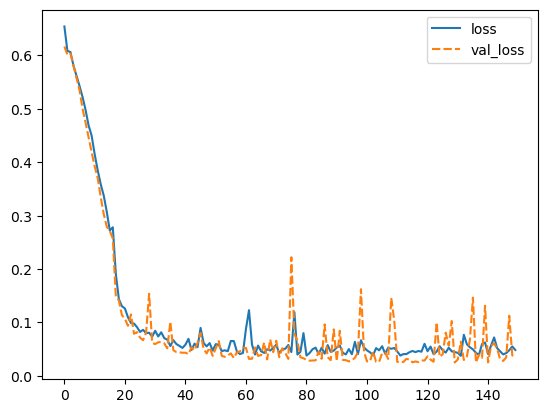

In [200]:
sns.lineplot(early_model.history.history)

In [201]:
ypred_prob_early = early_model.predict(xtest)
ypred = np.where(ypred_prob_early > 0.5, 1, 0)
ypred[:30].reshape(1,-1)

13/13 [==============================] - 0s 2ms/step


array([[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 0, 1]])

In [202]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       198
           1       0.99      0.98      0.99       200

    accuracy                           0.99       398
   macro avg       0.99      0.99      0.99       398
weighted avg       0.99      0.99      0.99       398



In [203]:
early_acc = round(accuracy_score(ytest, ypred), 3)
early_acc

0.987

#### Accuracy is `98.7%` when the threshold is 0.5
#### We will try to increase the accuracy by changing the threshold

### ROC AUC

In [204]:
auc = roc_auc_score(ytest, ypred_prob_early)
auc

0.9996969696969696

#### AUC of the model is `0.9996`

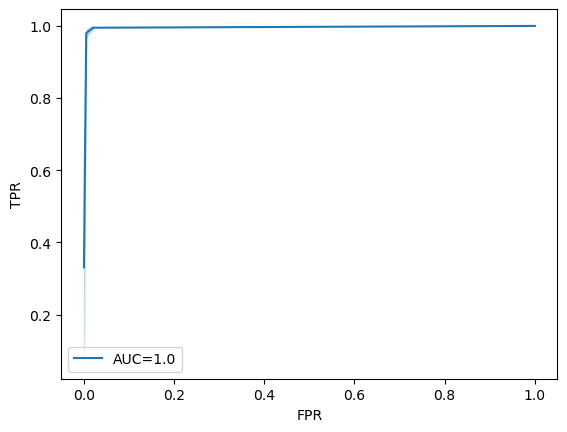

In [298]:
fpr, tpr, thresh = roc_curve(ytest, ypred_prob_early)
sns.lineplot(x=fpr, y=tpr, label=f'AUC={round(auc, 2)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### Selecting the threshold with the best accuracy

In [207]:
acc = []

for i in thresh:
    ypred = np.where(ypred_prob_early > i, 1, 0)
    acc.append(accuracy_score(ytest, ypred))

thresh_df = pd.DataFrame({'Accuracy': acc, 'Thresh': thresh})
thresh_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,Thresh
6,0.989950,0.331598
7,0.987437,0.093867
8,0.987437,0.070642
5,0.984925,0.605420
4,0.982412,0.615681
3,0.665829,0.999722
2,0.663317,0.999724
9,0.505025,0.000302
0,0.497487,1.999997
1,0.497487,0.999997


#### From above table we can see that when threshold is `0.331598`, accuracy is the highest, so we'll be using this threshold

In [208]:
ypred = np.where(ypred_prob_early > 0.331598, 1, 0)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       198
           1       0.99      0.98      0.99       200

    accuracy                           0.99       398
   macro avg       0.99      0.99      0.99       398
weighted avg       0.99      0.99      0.99       398



In [209]:
early_acc = round(accuracy_score(ytest, ypred), 3)
early_acc

0.99

#### So the model's accuracy using `Early Stopping method` and after selecting the best threshold is `99%` 

### DropOut method

In [210]:
drop_model = Sequential()
drop_model.add(Dense(units=10, activation='relu'))
drop_model.add(Dropout(rate=0.2))

drop_model.add(Dense(units=8, activation='relu'))
drop_model.add(Dropout(rate=0.2))

drop_model.add(Dense(units=5, activation='relu'))
drop_model.add(Dropout(rate=0.2))

drop_model.add(Dense(units=1, activation='sigmoid'))
drop_model.compile(optimizer='adam', loss='binary_crossentropy')

drop_model.fit(xtrain, ytrain, epochs=350, validation_data=(xtest, ytest))

Epoch 1/350
50/50 [==============================] - 1s 5ms/step - loss: 8.1786 - val_loss: 0.6763
Epoch 2/350
50/50 [==============================] - 0s 3ms/step - loss: 3.6876 - val_loss: 0.6901
Epoch 3/350
50/50 [==============================] - 0s 3ms/step - loss: 2.0549 - val_loss: 0.6821
Epoch 4/350
50/50 [==============================] - 0s 3ms/step - loss: 1.0201 - val_loss: 0.6500
Epoch 5/350
50/50 [==============================] - 0s 3ms/step - loss: 0.7767 - val_loss: 0.6473
Epoch 6/350
50/50 [==============================] - 0s 4ms/step - loss: 0.6808 - val_loss: 0.6594
Epoch 7/350
50/50 [==============================] - 0s 2ms/step - loss: 0.6640 - val_loss: 0.6580
Epoch 8/350
50/50 [==============================] - 0s 3ms/step - loss: 0.6670 - val_loss: 0.6605
Epoch 9/350
50/50 [==============================] - 0s 3ms/step - loss: 0.6676 - val_loss: 0.6623
Epoch 10/350
50/50 [==============================] - 0s 3ms/step - loss: 0.6639 - val_loss: 0.6567
Epoch 11/

50/50 [==============================] - 0s 2ms/step - loss: 0.4185 - val_loss: 0.2244
Epoch 84/350
50/50 [==============================] - 0s 2ms/step - loss: 0.4146 - val_loss: 0.2253
Epoch 85/350
50/50 [==============================] - 0s 3ms/step - loss: 0.4230 - val_loss: 0.2398
Epoch 86/350
50/50 [==============================] - 0s 3ms/step - loss: 0.4261 - val_loss: 0.2199
Epoch 87/350
50/50 [==============================] - 0s 3ms/step - loss: 0.3962 - val_loss: 0.2252
Epoch 88/350
50/50 [==============================] - 0s 3ms/step - loss: 0.4121 - val_loss: 0.2220
Epoch 89/350
50/50 [==============================] - 0s 2ms/step - loss: 0.3979 - val_loss: 0.2272
Epoch 90/350
50/50 [==============================] - 0s 3ms/step - loss: 0.4069 - val_loss: 0.2101
Epoch 91/350
50/50 [==============================] - 0s 2ms/step - loss: 0.4015 - val_loss: 0.2095
Epoch 92/350
50/50 [==============================] - 0s 3ms/step - loss: 0.3987 - val_loss: 0.2063
Epoch 93/350


50/50 [==============================] - 0s 3ms/step - loss: 0.3710 - val_loss: 0.3846
Epoch 246/350
50/50 [==============================] - 0s 3ms/step - loss: 0.3973 - val_loss: 0.1529
Epoch 247/350
50/50 [==============================] - 0s 4ms/step - loss: 0.3157 - val_loss: 0.1457
Epoch 248/350
50/50 [==============================] - 0s 3ms/step - loss: 0.3101 - val_loss: 0.1305
Epoch 249/350
50/50 [==============================] - 0s 3ms/step - loss: 0.3097 - val_loss: 0.1301
Epoch 250/350
50/50 [==============================] - 0s 2ms/step - loss: 0.3407 - val_loss: 0.1420
Epoch 251/350
50/50 [==============================] - 0s 4ms/step - loss: 0.3389 - val_loss: 0.2242
Epoch 252/350
50/50 [==============================] - 0s 4ms/step - loss: 0.3340 - val_loss: 0.1301
Epoch 253/350
50/50 [==============================] - 0s 3ms/step - loss: 0.3362 - val_loss: 0.1321
Epoch 254/350
50/50 [==============================] - 0s 4ms/step - loss: 0.3321 - val_loss: 0.1457
Epoc

<AxesSubplot:>

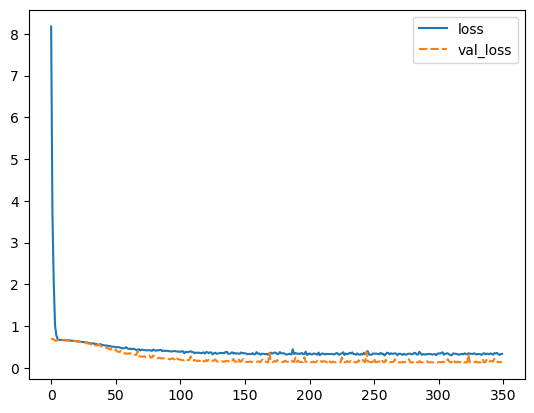

In [212]:
sns.lineplot(drop_model.history.history)

In [217]:
ypred_prob_drop = drop_model.predict(xtest)
ypred = np.where(ypred_prob_drop > 0.5, 1, 0)
ypred

13/13 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
    

In [218]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       198
           1       0.99      0.99      0.99       200

    accuracy                           0.99       398
   macro avg       0.99      0.99      0.99       398
weighted avg       0.99      0.99      0.99       398



In [219]:
drop_acc = round(accuracy_score(ytest, ypred), 4)
drop_acc

0.9925

#### Accuracy is `99.25%` when the threshold is 0.5
#### We will try to increase the accuracy by changing the threshold

### ROC AUC

In [220]:
auc = roc_auc_score(ytest, ypred_prob_drop)
auc

0.997361111111111

#### AUC of the model is `0.9973`

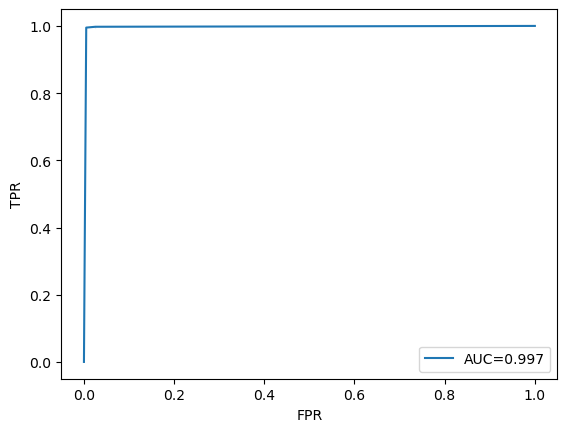

In [221]:
fpr, tpr, thresh = roc_curve(ytest, ypred_prob_drop)
sns.lineplot(x=fpr, y=tpr, label=f'AUC={round(auc, 3)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### Selecting the threshold with the best accuracy

In [222]:
acc = []

for i in thresh:
    ypred = np.where(ypred_prob_early > i, 1, 0)
    acc.append(accuracy_score(ytest, ypred))

thresh_df = pd.DataFrame({'Accuracy': acc, 'Thresh': thresh})
thresh_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,Thresh
2,0.987437,4.641133e-01
3,0.987437,4.593143e-01
1,0.972362,7.992535e-01
4,0.502513,1.105591e-11
0,0.497487,1.799253e+00


#### From above table we can see that when threshold is none of the thresholds can give a better accuracy than `0.5`, so we'll be using the same threshold

#### Model's accuracy using `Drop Out` method is `99.25%`

In [313]:
ann_acc_df = pd.DataFrame({'Accuracy': np.array([ann_accuracy, early_acc, drop_acc])*100}, 
                      index=['Original', 'Early Stopping', 'Drop Out'])
ann_acc_df.sort_values(by='Accuracy', ascending=False)

,Accuracy
Drop Out,99.25
Early Stopping,99.00
Original,98.50


#### From the above table we can see that the `Drop Out method` has the best accuracy amongst the other 2 models

### KNN

## Standardization

In [260]:
ss = StandardScaler()
xtrain = pd.DataFrame(ss.fit_transform(xtrain), columns=xtrain.columns)
xtest = pd.DataFrame(ss.fit_transform(xtest), columns=xtest.columns)
xtrain

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.435962,0.432866,-0.095722,0.216560,0.472877,-1.784763
1,-0.746841,0.357280,0.145495,-1.481074,-2.485575,0.328189
2,0.100963,0.392898,-1.196905,1.178175,0.835206,-0.379701
3,-1.289435,-0.105751,0.520118,0.927024,0.968037,0.284626
4,0.609646,-0.283840,0.769867,-1.525395,-1.290094,1.057859
...,...,...,...,...,...,...
1583,-0.543368,-0.924960,-0.010598,1.798667,-0.006059,-1.501432
1584,-0.407719,0.179191,0.114277,1.399779,-0.006059,0.121267
1585,0.575734,0.891546,-2.445649,-0.890129,0.348158,0.752922
1586,1.186153,-0.105751,-0.385221,-0.771941,0.303881,-0.793543


#### Building model using default params i.e. `n_neighbours=5`

In [307]:
knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)
ypred = knn.predict(xtest)
knn.score(xtrain, ytrain), knn.score(xtest, ytest)

(0.9924433249370277, 0.9849246231155779)

#### There is some difference in the scores for training and testing data but we can try to reduce it

In [301]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       198
           1       0.99      0.97      0.98       200

    accuracy                           0.98       398
   macro avg       0.99      0.98      0.98       398
weighted avg       0.99      0.98      0.98       398



In [302]:
knn_acc = round(accuracy_score(ytest, ypred), 4)
knn_acc

0.9849

#### Accuracy of the `KNN` model without Hyperparameter Tuning is `98.49%`

### Hyperparamter Tuning

In [282]:
train_acc = []
test_acc = []

for i in range(1, 31):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(xtrain, ytrain)
    ypred_ = model.predict(xtest)
    train_acc.append(model.score(xtrain, ytrain))
    test_acc.append(model.score(xtest, ytest))

<AxesSubplot:>

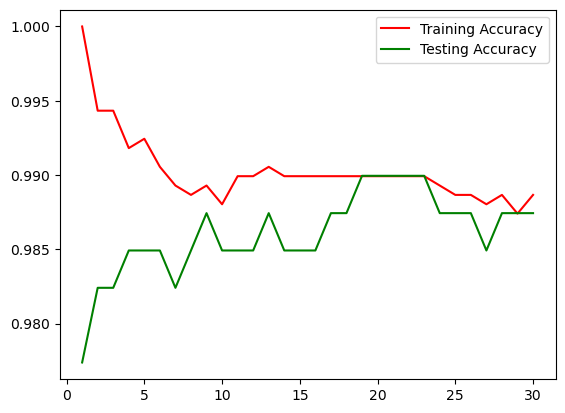

In [283]:
sns.lineplot(x=range(1, 31), y=train_acc, label='Training Accuracy', color='r')
sns.lineplot(x=range(1, 31), y=test_acc, label='Testing Accuracy', color='g')

In [308]:
final_knn = KNeighborsClassifier(n_neighbors=19)
final_knn.fit(xtrain, ytrain)
ypred = final_knn.predict(xtest)
final_knn.score(xtrain, ytrain), final_knn.score(xtest, ytest)

(0.9899244332493703, 0.9899497487437185)

#### We can see that the accuracies are almost similar and the difference has reduced

In [309]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       198
           1       0.99      0.98      0.99       200

    accuracy                           0.99       398
   macro avg       0.99      0.99      0.99       398
weighted avg       0.99      0.99      0.99       398



In [312]:
final_knn_acc= round(accuracy_score(ytest, ypred), 4)
final_knn_acc

0.9899

#### Final model's accuracy using `n_neighbours=19` is 98.99%

In [314]:
knn_acc_df = pd.DataFrame({'Accuracy': [knn_acc, final_knn_acc]}, index=['Original Model', 'Final Model'])
knn_acc_df.sort_values(by='Accuracy', ascending=False)

,Accuracy
Final Model,0.9899
Original Model,0.9849


In [32]:
X = balanced_df.drop('is_genuine', axis=1)
y = balanced_df['is_genuine']

In [33]:
from sklearn.decomposition import PCA 
#PCA will help to reduce the number of features while preserving the most important information in the data

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


# DECISION TREE

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [36]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]}

In [37]:
# Create the Decision Tree model
dt_model = DecisionTreeClassifier()

In [38]:
# Create the GridSearchCV object
dt_grid_search = GridSearchCV(dt_model, param_grid, cv=5)

In [39]:
# Fit the GridSearchCV object to the data
dt_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6]})

In [40]:
# Print the best parameters
print(dt_grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [41]:
# Use the hyperparameters
params = {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 4}

In [42]:
dt_model = DecisionTreeClassifier(**params, random_state=42)

In [43]:
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [44]:
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))

Decision Tree Accuracy: 0.9723618090452262


# RANDOM FOREST

In [45]:
from sklearn.ensemble import RandomForestClassifier


In [46]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}


In [47]:
# Create a new random forest model
rf_model = RandomForestClassifier(random_state=42)


In [48]:
# Set up the grid search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]})

In [49]:
# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [50]:
# Initialize the random forest classifier with best hyperparameters
rfc = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=1, min_samples_split=2, random_state=42)


In [51]:
# Train the model
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=42)

In [52]:
# Evaluate the model
score = rfc.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.9824120603015075


# COMPARISION USING CROSS VALIDATION

In [53]:
from sklearn.model_selection import cross_val_score
# Initialize the decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)

In [54]:
# Perform 5-fold cross-validation to get the accuracy scores
dtc_scores = cross_val_score(dtc, X, y, cv=5)

In [55]:

# Print the mean accuracy score of the decision tree classifier
print("Decision Tree Mean Accuracy:", dtc_scores.mean())


Decision Tree Mean Accuracy: 0.9864144399579763


In [56]:
# Initialize the random forest classifier with best hyperparameters
rfc = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=1, min_samples_split=2, random_state=42)

In [57]:
# Perform 5-fold cross-validation to get the accuracy scores
rfc_scores = cross_val_score(rfc, X, y, cv=5)


In [58]:
# Print the mean accuracy score of the random forest classifier
print("Random Forest Mean Accuracy:", rfc_scores.mean())

Random Forest Mean Accuracy: 0.9929521663734289


# Boosting

In [289]:
ada_model=AdaBoostClassifier(random_state=1)
ada_model.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [290]:
y_pred_clf=ada_model.predict(X_train)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        92
           1       0.99      1.00      0.99       208

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



In [294]:
scores = cross_val_score(ada_model, X_train, y_train, cv=100)
print("Accuracy: {:.2f} % (+/- {:.2f} %)".format(scores.mean() * 100, scores.std() * 100))

Accuracy: 98.83 % (+/- 3.12 %)


<AxesSubplot:xlabel='Importance'>

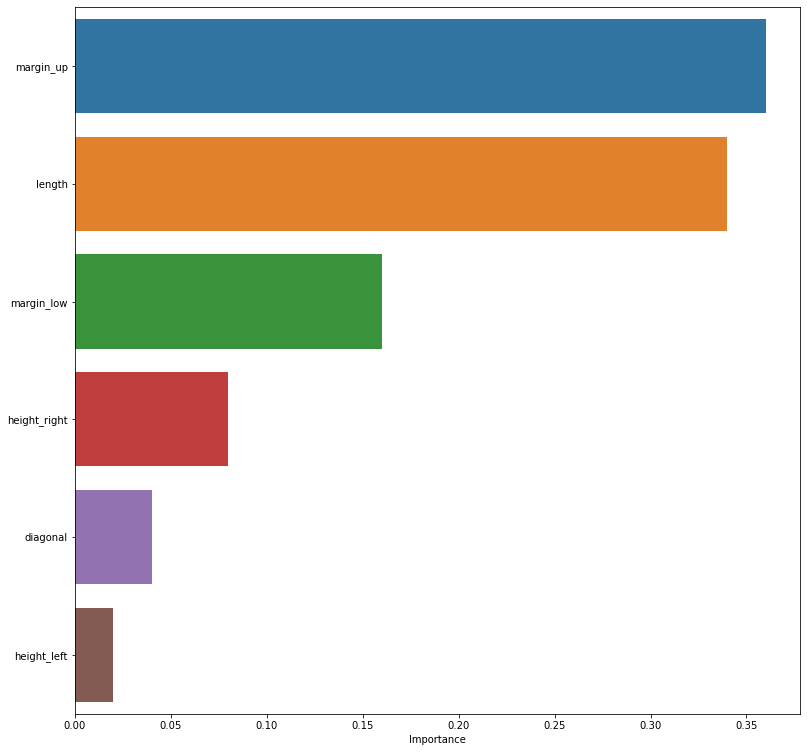

In [295]:
#Let's look at the feature importance.
importances = ada_model.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns,columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(x = importance_df.Importance, y = importance_df.index)

# Naive Bayes

In [39]:
clf_model=GaussianNB()

In [40]:
#fitting the model
clf_model.fit(X_train, y_train)

GaussianNB()

In [41]:
#Testing the model
y_pred_clf = clf_model.predict(X_test)

In [48]:
print(classification_report(y_test,y_pred_clf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       148
           1       0.99      1.00      1.00       302

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



WHOA!the model returns a 99% accuary! Now I Wonder if there's overfitting that happend.Let's try and cross validate our model

In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_model, X_train, y_train, cv=10)
print("Accuracy: {:.2f} % (+/- {:.2f} %)".format(scores.mean() * 100, scores.std() * 100))

Accuracy: 99.05 % (+/- 0.85 %)


Observation:
 Based on the results of the cross-validation, it appears that the model is performing well.

# Bagging 

#### BaggingClassifier With DecisionTreeClassifier

In [34]:
bg = BaggingClassifier(DecisionTreeClassifier(),n_estimators=30)

In [35]:
bg.fit(xtrain,ytrain)
ypred = bg.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        98
           1       0.99      0.98      0.98       202

    accuracy                           0.98       300
   macro avg       0.97      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [36]:
print('Train Accuracy:',bg.score(xtrain,ytrain))
print('Test Accuracy:',bg.score(xtest,ytest))

Train Accuracy: 1.0
Test Accuracy: 0.98


#### BaggingClassifier With DecisionTreeClassifier(criterion='entropy')

In [37]:
bg1 = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'),n_estimators=15)

In [38]:
bg1.fit(xtrain,ytrain)
ypred1 = bg1.predict(xtest)
print(classification_report(ytest,ypred1))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        98
           1       0.99      0.96      0.97       202

    accuracy                           0.97       300
   macro avg       0.96      0.97      0.96       300
weighted avg       0.97      0.97      0.97       300



In [39]:
print('Train Accuracy:',bg1.score(xtrain,ytrain))
print('Test Accuracy:',bg1.score(xtest,ytest))

Train Accuracy: 1.0
Test Accuracy: 0.9666666666666667


#### BaggingClassifier With KNeighborsClassifier

In [59]:
bg2 = BaggingClassifier(KNeighborsClassifier(),n_estimators=20)

In [60]:
bg2.fit(xtrain,ytrain)
ypred2 = bg2.predict(xtest)
print(classification_report(ytest,ypred2))

NameError: name 'xtrain' is not defined

In [42]:
print('Train Accuracy:',bg2.score(xtrain,ytrain))
print('Test Accuracy:',bg2.score(xtest,ytest))

Train Accuracy: 0.9908333333333333
Test Accuracy: 0.9966666666666667


#### BaggingClassifier With LogisticRegression

In [43]:
bg3 = BaggingClassifier(LogisticRegression(),n_estimators=20)

In [44]:
bg3.fit(xtrain,ytrain)
ypred3 = bg3.predict(xtest)
print(classification_report(ytest,ypred3))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        98
           1       1.00      1.00      1.00       202

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [45]:
print('Train Accuracy:',bg3.score(xtrain,ytrain))
print('Test Accuracy:',bg3.score(xtest,ytest))

Train Accuracy: 0.99
Test Accuracy: 0.9933333333333333


## Stacking

In [46]:
models = []

models.append(('lr',LogisticRegression()))
models.append(('dt',DecisionTreeClassifier()))
models.append(('dt1',DecisionTreeClassifier(criterion='entropy')))
models.append(('knn',KNeighborsClassifier()))
models.append(('rf',RandomForestClassifier()))

In [47]:
Stackclassifier = StackingClassifier(estimators=models,final_estimator=LogisticRegression(),cv=10)

In [48]:
Stackclassifier.fit(xtrain,ytrain)
ypred = Stackclassifier.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        98
           1       1.00      0.99      0.99       202

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [49]:
print('Train Accuracy:',Stackclassifier.score(xtrain,ytrain))
print('Test Accuracy:',Stackclassifier.score(xtest,ytest))

Train Accuracy: 0.9991666666666666
Test Accuracy: 0.99


# Logistic Regression 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,roc_curve

In [37]:
#Train a logistic regression model
logreg = LogisticRegression(random_state=1)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [38]:
#Evaluate the logistic regression model
y_pred = logreg.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 97   1]
 [  0 202]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



In [39]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred)*100)

Logistic Regression Accuracy: 99.66666666666667


In [40]:
print('Training Accuracy is:', logreg.score(X_train, y_train))
print('Testing Accuracy is:', logreg.score(X_test,y_test))

Training Accuracy is: 0.9916666666666667
Testing Accuracy is: 0.9966666666666667


# 2.support Vector  Machine

In [41]:
# import the required library
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [42]:
SVC()

SVC()

In [43]:
# Define the parameter
params={"kernel":["rbf","linear"],
          "gamma":[0.01,0.0001,1,5,0.1,4,5],
          "C":[50,15,10,0.1,6,2,5]}

In [44]:
grid=GridSearchCV(SVC(),param_grid=params)

In [45]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [50, 15, 10, 0.1, 6, 2, 5],
                         'gamma': [0.01, 0.0001, 1, 5, 0.1, 4, 5],
                         'kernel': ['rbf', 'linear']})

In [46]:
grid.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [47]:
grid.best_score_

0.9908333333333333

In [57]:
model = SVC(C = 0.1, gamma = 0.1,kernel='rbf')
model.fit(X_train , y_train)

SVC(C=0.1, gamma=0.1)

In [58]:
y_pred = model.predict(X_test)
y_pred

array([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1], d

In [59]:
confusion_matrix(y_test, y_pred)

array([[ 97,   1],
       [  0, 202]], dtype=int64)

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



In [61]:
print(" SVM Accuracy:", accuracy_score(y_test, y_pred)*100)

 SVM Accuracy: 99.66666666666667


In [64]:
print('Training Accuracy is:', model .score(X_train, y_train))
print('Testing Accuracy is:', model.score(X_test,y_test))

Training Accuracy is: 0.9925
Testing Accuracy is: 0.9966666666666667


In [65]:
from sklearn.model_selection import cross_val_score

In [66]:
lrc= LogisticRegression(random_state=1)

In [67]:
# Perform 5-fold cross-validation to get the accuracy scores
lrc_scores = cross_val_score(lrc, X, y, cv=5)

In [68]:
# Print the mean accuracy score 
print("Logistic regression mean Accuracy:", lrc_scores.mean())

Logistic regression mean Accuracy: 0.9893333333333334


In [71]:
svc=SVC(C=0.1,gamma=0.1,kernel='rbf')

In [72]:
svc_scores = cross_val_score(svc, X, y, cv=5)

In [73]:
print("SVM Mean Accuracy:", svc_scores.mean())

SVM Mean Accuracy: 0.99


### Accuracies Summary

In [55]:
all_acc

,Accuracy(%)
Bagging,99.66
SVC,99.66
Logistic Regression,99.33
ANN,99.25
Naive Bayes,99.05
Stacking,99.00
KNN,98.99
Random Forest,98.99
Boosting,98.83
Decision Tree,98.24


#### We will be using Bagging Model with KNN as it gives the maximum accuracy

In [6]:
dump(bg2, open('finalized_model_Bagging_KNN_.pkl', 'wb'))